In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:00, 152MB/s]


In [2]:
!pip install imbalanced-learn
!pip install scikit-learn==0.24
!pip install catboost
!pip install tldextract

     |████████████████████████████████| 22.3 MB 6.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 67.4 MB 56 kB/s 
     |████████████████████████████████| 87 kB 2.5 MB/s 


# Dependencies

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


import time
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import re
from wordcloud import WordCloud
from tldextract import extract
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

# Support

In [4]:
def func_roc_auc(proba, y):
    sns.set(style="whitegrid", palette='Dark2')
    
    auc = roc_auc_score(np.array(y), np.transpose(proba)[1])
    print(f'Лучшее качество auc_best_estimator: {auc:.3}')
    
    fpr, tpr, _ = roc_curve(y, proba[:,1])
    
    f = plt.figure()
    plt.plot(fpr, tpr, label = 'best_estimator')
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [5]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('roc_auc')
    plt.show()

In [6]:
def merge_data_and_domain(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "domain":"domain"+str(i)}).loc[:, ["webpage"+str(i), "domain"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["domain"+str(i) for i in range(1,11)]].fillna("left")
    string["string"] = string.apply(lambda x: " ".join(x.values[1:]), axis=1)
    string.loc[:, "preproc_tokens"] = string.loc[:, "string"].apply(lambda x: x.split(' ')).values
    return string

In [7]:
def merge_data_and_suf(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), "suf":"suf"+str(i)}).loc[:, ["webpage"+str(i), "suf"+str(i)]], on="webpage"+str(i), how="left")

    string = data.loc[:, ["session_id"]+["suf"+str(i) for i in range(1,11)]].fillna("no_data").replace("", "empty")
    return string

In [8]:
def train_word2vec(train_domain_features, test_domain_features, 
                   size, window, min_count, workers, sg, refit):
    # Store the model in following file
    word2vec_model_file = OUTPUT_FOLDER + '/word2vec_' + str(size) + '.model'
    # Store the vectors for train data in following file
    word2vec_filename = OUTPUT_FOLDER + '/train_review_word2vec.csv'
    if refit:
        start_time = time.time()
        preproc_tokens = pd.Series(train_domain_features['preproc_tokens']).values
        # Train the Word2Vec Model
        w2v_model = Word2Vec(preproc_tokens, min_count=min_count, size=size, workers=workers, window=window, sg=sg)
        print(f"Time taken to train word2vec model: {(time.time() - start_time)/60:0.03} min")
        # save model to file
        w2v_model.save(word2vec_model_file)

        # save emb to file
        with open(word2vec_filename, 'w+') as word2vec_file:
            print("data shape: ", train_domain_features.shape[0])
            for index, row in tqdm_notebook(train_domain_features.iterrows()):
                model_vector = (np.mean([w2v_model[token] for token in row['preproc_tokens']], axis=0)).tolist()
                if index == 0:
                    header = ",".join(str(x) for x in range(size))
                    word2vec_file.write(header)
                    word2vec_file.write("\n")
                # Check if the line exists else it is vector of zeros
                if type(model_vector) is list:  
                    line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
                else:
                    line1 = ",".join([str(0) for i in range(size)])
                word2vec_file.write(line1)
                word2vec_file.write('\n')
    else:
        # Load model
        w2v_model = Word2Vec.load(word2vec_model_file)

    # Load train from the filename
    word2vec_train = pd.read_csv(word2vec_filename)

    test_features_word2vec = np.array([x for x in range(size)])
    test_ = np.array([0 for x in range(size)])
    print("data shape: ", test_domain_features.shape[0])
    for index, row in tqdm_notebook(test_domain_features.iterrows()):
        model_vector = np.mean([w2v_model[token] for token in row['preproc_tokens'] if token in w2v_model.wv.vocab], axis=0)
        if type(model_vector) is np.ndarray:
            test_ = np.vstack([test_, model_vector])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
        else:
            test_ = np.vstack([test_, np.array([0 for i in range(size)])])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
    test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])

    word2vec_test = pd.DataFrame(test_features_word2vec[1:])

    return word2vec_train, word2vec_test

In [9]:
def time_features_extraction(data):
    time_data  = data.loc[:, ["time"+str(i) for i in range(1,11)]]

    for column in time_data.columns:
        time_data[column] = pd.to_datetime(time_data[column])

    time_data = time_data.assign(
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1),
            # avg hour of day in a session
            avg_hour=lambda x: np.round(x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1)),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1)
        )

    for i in range(1,10):
        time_data["delta"+str(i)] = (time_data["time" + str(i+1)] - time_data["time" + str(i)]).dt.seconds
    
    time_data.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True)

    time_data.fillna(0, inplace=True)

    return time_data

In [10]:
def unique_features(domain_features):
    n_unique = domain_features.assign(
        nans_count=lambda x: x.isna().sum(axis=1),
        # number of unique pages in session
        n_unique_pages=lambda x: x.filter(like='domain').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count)).loc[:, ["session_id", "n_unique_pages"]]

    return n_unique

In [11]:
def text_preprocessing_1(text):
    clean_text = re.split("\.|-", text)
    clean_text = [x for x in clean_text if len(x)>1]
    clean_text = " ".join(clean_text)
    clean_text = re.sub("[a-z]*[0-9]", "", clean_text)
    clean_text = re.sub(' +', ' ', clean_text)

    return clean_text, domen

In [12]:
def text_preprocessing_2(text, vocab):
    clean_text =  text.split(" ")
    clean_text = [x for x in clean_text if x in vocab]
    clean_text =  " ".join(clean_text)
    return clean_text

In [51]:
def save_submission(pred, number):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/submissions_test/notebook_submission' + str(number) + '.csv')

# Preprocessing

In [14]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/model_test"

In [21]:
train = pd.read_csv("./train.csv")
x_test = pd.read_csv('./test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test.reset_index(inplace=True)
id_map = pd.read_parquet("/content/id_map.parquet")

In [22]:
# get user's webpages 
user_frame = train.loc[train["target"]==1].reset_index(drop=True)

array = np.array([])
for element in ["webpage"+str(x) for x in range(1,11)]:
    unique_array = user_frame.loc[:, element].unique()
    array = np.concatenate([array, unique_array])
array = {x for x in array if x==x}

id_map["target"] = 0
id_map.loc[id_map["id"].isin(array), "target"] = 1

In [23]:
x_train, y_train = train.drop(columns=["target"]), train.loc[:, ["target"]]

In [24]:
# extract "sub-domain", "domain", "suf" from url of webpage
list_ = [list(extract(id_map.loc[i].webpage)) for i in id_map.index]
id_map.loc[:, ["sub","domain","suf"]] = list_

In [25]:
%%time
train_suf_features = merge_data_and_suf(x_train, id_map)
test_suf_features = merge_data_and_suf(x_test, id_map)

CPU times: user 3.78 s, sys: 73.5 ms, total: 3.86 s
Wall time: 3.87 s


In [26]:
%%time
train_domain_features = merge_data_and_domain(x_train, id_map)
test_domain_features = merge_data_and_domain(x_test, id_map)

CPU times: user 6.38 s, sys: 240 ms, total: 6.62 s
Wall time: 6.62 s


In [27]:
%%time
n_unique_train = unique_features(train_domain_features)
n_unique_test = unique_features(test_domain_features)

CPU times: user 23.8 s, sys: 1.05 s, total: 24.8 s
Wall time: 23.5 s


In [28]:
word2vec_train, word2vec_test = train_word2vec(train_domain_features, test_domain_features, sg=1,
                                               size=150, window=2, min_count=1, workers=3, refit=True)

Time taken to train word2vec model: 0.277 min
data shape:  159969


0it [00:00, ?it/s]

data shape:  93338


0it [00:00, ?it/s]

In [30]:
%%time
train_set = pd.concat([train_suf_features, n_unique_train.iloc[:, 1:], word2vec_train], axis=1)
train_set.set_index("session_id", inplace=True)
test_set = pd.concat([test_suf_features, n_unique_test.iloc[:, 1:], word2vec_test], axis=1)
test_set.set_index("session_id", inplace=True)

CPU times: user 269 ms, sys: 68.5 ms, total: 338 ms
Wall time: 339 ms


In [33]:
%%time
time_train = time_features_extraction(x_train)
time_test = time_features_extraction(x_test)

CPU times: user 1.59 s, sys: 20.7 ms, total: 1.61 s
Wall time: 1.61 s


In [34]:
%%time
train_set = pd.concat([train_set, time_train], axis=1)
test_set = pd.concat([test_set, time_test], axis=1)

CPU times: user 201 ms, sys: 124 ms, total: 325 ms
Wall time: 327 ms


In [37]:
%%time
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_set.loc[:, ["suf"+str(i) for i in range(1, 11)]] = encoder.fit_transform(train_set.loc[:, ["suf"+str(i) for i in range(1, 11)]])
test_set.loc[:, ["suf"+str(i) for i in range(1, 11)]] = encoder.transform(test_set.loc[:, ["suf"+str(i) for i in range(1, 11)]], )

CPU times: user 2.17 s, sys: 159 ms, total: 2.33 s
Wall time: 2.34 s


In [39]:
%%time
sm = SMOTE(random_state=42, k_neighbors=7, sampling_strategy=0.20)
train_resampled, y_train_resampled = sm.fit_resample(train_set, y_train)

CPU times: user 727 ms, sys: 330 ms, total: 1.06 s
Wall time: 989 ms


In [42]:
%%time
model = CatBoostClassifier(learning_rate=0.03, depth=10, l2_leaf_reg=3, iterations=200, 
                           auto_class_weights = "Balanced", loss_function = "Logloss", 
                           random_state=42)

# Обучаем estimator
model.fit(train_set, y_train)

0:	learn: 0.6523177	total: 1.25s	remaining: 4m 8s
1:	learn: 0.6178722	total: 2.32s	remaining: 3m 49s
2:	learn: 0.5767868	total: 3.37s	remaining: 3m 41s
3:	learn: 0.5461828	total: 4.46s	remaining: 3m 38s
4:	learn: 0.5177372	total: 5.61s	remaining: 3m 38s
5:	learn: 0.4939463	total: 6.7s	remaining: 3m 36s
6:	learn: 0.4753177	total: 7.77s	remaining: 3m 34s
7:	learn: 0.4552986	total: 8.87s	remaining: 3m 32s
8:	learn: 0.4348699	total: 10s	remaining: 3m 32s
9:	learn: 0.4146418	total: 11.2s	remaining: 3m 32s
10:	learn: 0.3979082	total: 12.3s	remaining: 3m 31s
11:	learn: 0.3859565	total: 13.3s	remaining: 3m 28s
12:	learn: 0.3754240	total: 14.3s	remaining: 3m 26s
13:	learn: 0.3621690	total: 15.5s	remaining: 3m 25s
14:	learn: 0.3487563	total: 16.5s	remaining: 3m 23s
15:	learn: 0.3410419	total: 17.6s	remaining: 3m 22s
16:	learn: 0.3270752	total: 18.6s	remaining: 3m 20s
17:	learn: 0.3173966	total: 19.7s	remaining: 3m 19s
18:	learn: 0.3090095	total: 20.8s	remaining: 3m 18s
19:	learn: 0.2988062	total

Лучшее качество auc_best_estimator: 0.999


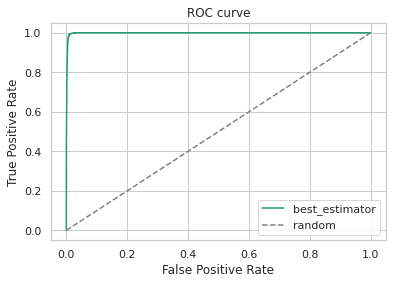

In [44]:
probas = model.predict_proba(train_set.to_numpy())
func_roc_auc(proba=probas, y=y_train.to_numpy())

In [45]:
probas = model.predict_proba(test_set.to_numpy())[:, 1]

In [52]:
save_submission(probas, number=5)